In [7]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt

# number of inner corners in each row/col
rows = 10
cols = 7

# Prepare object points
objp = np.zeros((1, rows * cols, 3), np.float32)
objp[0, :, :2] = np.mgrid[0:cols, 0:rows].T.reshape(-1, 2)

# Arrays to store object points and image points
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane

# Iterate through calibration images
for fname in glob.glob('bmmsc/*.jpg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (cols,rows), None)

    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(
            gray,corners, (11,11), (-1,-1),
            (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 1e-3))
        imgpoints.append(corners)

# Calibrate
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]
flags = (
    cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_CHECK_COND
    + cv2.fisheye.CALIB_FIX_SKEW)
ret, _, _, _, _ = cv2.fisheye.calibrate(
    objpoints, imgpoints, gray.shape[::-1], K, D, rvecs, tvecs, flags,
    criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))

In [14]:
import json

with open("camera.json", 'w') as f:
    json.dump({
        "fx": K[0, 0],
        "fy": K[1, 1],
        "cx": K[0, 2],
        "cy": K[1, 2],
        "k": D[:, 0].tolist(),
        "p": [0, 0]
    }, f, indent=4)


with open("camera_ns.json", 'w') as f:
    json.dump({
        "w": 1920,
        "h": 1080,
        "fl_x": K[0, 0],
        "fl_y": K[1, 1],
        "cx": K[0, 2],
        "cy": K[1, 2],
        "k1": D[0, 0],
        "k2": D[1, 0],
        "k3": D[2, 0],
        "k4": D[3, 0],
        "p1": 0,
        "p2": 0,
        "camera_model": "OPENCV_FISHEYE"
    }, f, indent=4)

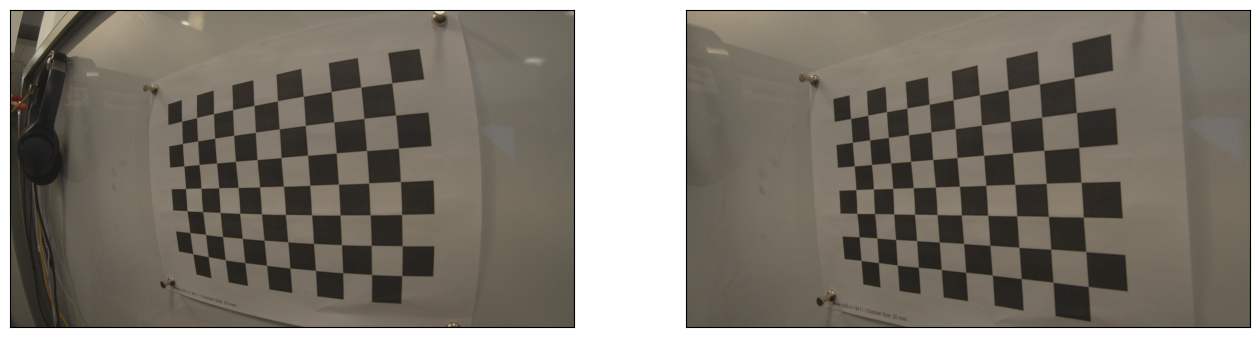

In [10]:
# Use K and D to undistort images
map1, map2 = cv2.fisheye.initUndistortRectifyMap(
    K, D, np.eye(3), K, gray.shape[::-1], cv2.CV_32FC1)

for fname in glob.glob('_bmmsc/*.jpg'):
    img = cv2.imread(fname)
    undistorted_img = cv2.remap(
        img, map1, map2, interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT)

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    axs[0].imshow(img[..., [2, 1, 0]])
    axs[1].imshow(undistorted_img[..., [2, 1, 0]])

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    
    break